In [7]:
# import necessary libraries
import numpy as np # library for numerical computing with arrays
import xarray as xr # library for working with labeled multidimensional arrays
import math # library for common math functions
from math import radians, cos, sin, asin, sqrt

def find_nearest(array, value):
    '''
    finds value and idx of value in array that is closest to the looked for value
    '''
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def unique(sequence):
    '''
    finds unique values of array while keeping the order of values in array
    (set() orders values in increasing way)
    '''
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def section_indices(data,point1,point2):
    '''
    get x,y indices of section between latlon point1 and point2
    
    uses haversine distance to look for closest points on latlon grid to given latlon point
    
    first defines straight latlon line between point1 and point2
    
    then looks for closest points on grids to this line
    
    straight line has higher resolution than grid, so we discard all the x,y points that appear twice
    '''
    lat = np.asarray(data.ULAT.data)
    lon = np.asarray(data.ULONG.data)
    
    if len(lat.shape) == 1 & len(lon.shape) == 1:
        lon,lat = np.meshgrid(lon,lat)
    
    lat1,lon1 = point1
    lat2,lon2 = point2
    

    f = np.frompyfunc(haversine,4,1)
    value, indices1 = find_nearest(f(lon,lat,lon1,lat1).astype(float),0)
    value, indices2 = find_nearest(f(lon,lat,lon2,lat2).astype(float),0)

    x_dist = np.abs(indices1[1] - indices2[1]) 
    y_dist = np.abs(indices1[0] - indices2[0]) 

    dist_max = max(x_dist,y_dist)

    if (lat1-lat2) == 0:
        longitudes = np.linspace(lon1, lon2, dist_max*2)
        latitudes = np.ones(dist_max*2)*lat1
    elif (lon1-lon2) == 0:
        latitudes = np.linspace(lat1, lat2, dist_max*2)
        longitudes = np.ones(dist_max*2)*lon1
    else:
        latitudes = np.linspace(lat1, lat2, dist_max*2)
        longitudes = (lon2 - lon1)/(lat2 - lat1)*(latitudes - lat1) + lon1

    # x_idx = []
    # y_idx = []
    indices = []
    
    for i in range(dist_max*2):
        dummy = find_nearest(f(lon,lat,longitudes[i],latitudes[i]).astype(float),0)[1]
        # x_idx.append(dummy[1])
        # y_idx.append(dummy[0])
        indices.append((dummy[1],dummy[0]))
    indices = unique(indices)
    x_idx = [x[0] for x in indices]
    y_idx = [x[1] for x in indices]
    
    return x_idx,y_idx,latitudes,longitudes

In [4]:
grid = xr.open_dataset('/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc',
                         chunks={'nlon':50,'nlat':50})

mask = grid.isel(nlon=slice(1100,1500),nlat=slice(650,850)).load()

In [5]:
lat_min_West = -45
lat_max_West = -33
lon_min_West = 3
lon_max_West = 8

lat_min_Northwest = -33
lat_max_Northwest = -33
lon_min_Northwest = 8
lon_max_Northwest = 18

In [11]:
x_idx_West,y_idx_West,latitudes,longitudes = section_indices(mask,(lat_min_West,lon_min_West),(lat_max_West,lon_max_West))
x_idx_Northwest,y_idx_Northwest,latitudes,longitudes = section_indices(mask,(lat_min_Northwest,lon_min_Northwest),(lat_max_Northwest,lon_max_Northwest))

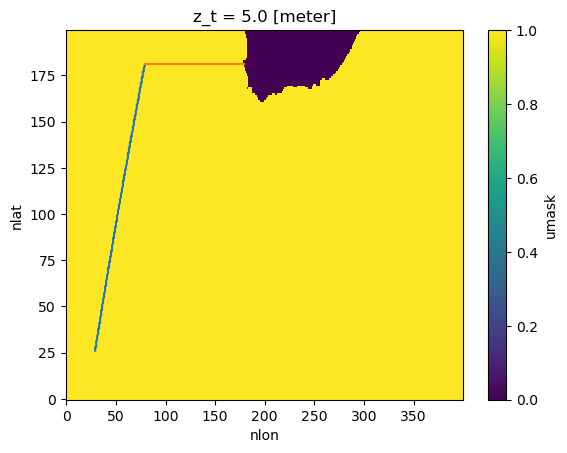

In [12]:
mask.umask[0,:,:].plot()
plt.plot(x_idx_West,y_idx_West)
plt.plot(x_idx_Northwest,y_idx_Northwest)